About today's task background

1.   [GLUE](https://gluebenchmark.com/)
2.   [SUPER GLUE](https://super.gluebenchmark.com/)
3.   [RUSSIAN SUPER GLUE](https://russiansuperglue.com/) 




In [ ]:
!pip install ipymarkup
!pip install transformers

In [ ]:
# run once
# !wget https://russiansuperglue.com/tasks/download/RUSSE
# !mv RUSSE RUSSE.zip
# !unzip RUSSE.zip

In [ ]:
!head RUSSE/train.jsonl

{"idx" : 0, "word" : "двор", "sentence1" : "В нашей деревне осталось от силы двадцать дворов", "sentence2" : "Солнце стояло уже высоко, когда справа от дороги я увидел деревеньку дворов в пятнадцать", "start1" : 42, "end1" : 49, "start2" : 69, "end2" : 76, "label" : true, "gold_sense1" : 1, "gold_sense2" : 1}
{"idx" : 1, "word" : "доклад", "sentence1" : "Табличка на дверях: «Без доклада не входить»", "sentence2" : "Вчера отбыл в столицу первый секретарь обкома […], вызванный то ли «на ковёр», то ли на сезонный доклад об урожае", "start1" : 25, "end1" : 33, "start2" : 97, "end2" : 104, "label" : false, "gold_sense1" : 4, "gold_sense2" : 2}
{"idx" : 2, "word" : "засада", "sentence1" : "У нас вообще […] засада с героями, способными дотягивать в жизни до собственного творчества", "sentence2" : "Там в воскресенье все магазины закрыты – вот ведь засада!", "start1" : 17, "end1" : 24, "start2" : 50, "end2" : 57, "label" : true, "gold_sense1" : 2, "gold_sense2" : 2}
{"idx" : 3, "word" : "доля",

In [ ]:
import json
import os

class DataReader:

  file_mapping = {
      "TRAIN": "train.jsonl",
      "TEST": "test.jsonl",
      "VALID": "val.jsonl"
  }

  def __init__(self, dir_path):
      self.train_samples = self.read_file(dir_path, "TRAIN")
      self.test_samples = self.read_file(dir_path, "TEST")
      self.valid_samples = self.read_file(dir_path, "VALID")

  def read_file(self, dir_path, file_name):
      file_path = os.path.join(dir_path, self.file_mapping[file_name])
      jsonl_content = open(file_path).read()
      samples = [json.loads(jline) for jline in jsonl_content.splitlines()]
      print(f"Number of samples - {len(samples)} - in {file_name} dataset ")
      return samples

In [ ]:
dr = DataReader("./RUSSE")

Number of samples - 19845 - in TRAIN dataset 
Number of samples - 18892 - in TEST dataset 
Number of samples - 8505 - in VALID dataset 


In [ ]:
import pandas as pd


class DataProcessor:

  sentence_keys = ["sentence1", "sentence2"]
  word_key = "word"
  target_label_key = "label"
  
  sentence_separator = "\n"
  dataframe_keys = ["text", "labels", "word"]

  def __init__(self, samples):
    self.text_data, self.target_labels, self.target_words = self.prepare_data(samples)

  def prepare_data(self, samples):
    sentences_pairs = []
    labels = []
    words = []
    for indx, sample in enumerate(samples):
      assert isinstance(sample, dict), \
       f"type(sample) should be dict but sample #{indx} is {type(sample)}"
      sentences_pair = []
      for sentence_key in self.sentence_keys:
        sentences_pair.append(sample[sentence_key])
      sentences_pair = self.sentence_separator.join(sentences_pair)
      sentences_pairs.append(sentences_pair)
      labels.append(sample.get(self.target_label_key))
      words.append(sample.get(self.word_key))

    return sentences_pairs, labels, words

  def to_dataframe(self):
    return pd.DataFrame({
        self.dataframe_keys[0]: self.text_data,
        self.dataframe_keys[1]: self.target_labels,
        self.dataframe_keys[2]: self.target_words,
        })
        
dp_train = DataProcessor(dr.train_samples).to_dataframe()
dp_valid = DataProcessor(dr.valid_samples).to_dataframe()

Значение лейбла у примера: 

* **True** если слово употреблено в двух предложениях в одном и том же значении
* **False** если слово употреблено в двух предложениях в разных значениях

In [ ]:
dp_train

,text,labels,word
0,В нашей деревне осталось от силы двадцать двор...,True,двор
1,Табличка на дверях: «Без доклада не входить»\n...,False,доклад
2,"У нас вообще […] засада с героями, способными ...",True,засада
3,"Он не успел сказать и десятой доли того, что с...",False,доля
4,"Теперь, если она не пойдет звонить мужу, успее...",False,закат
...,...,...,...
19840,Что у вас есть из рыбных закусок?\nПоявляются ...,True,закуска
19841,Рыбный дух за столетия пропитал темные каменны...,False,дух
19842,Васильки размножают делением корневищ и посево...,False,деление
19843,Что делать в случае задержки поезда в пути?\nЗ...,False,задержка


### [Logistic regression explained](https://towardsdatascience.com/logistic-regression-explained-9ee73cede081)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='liblinear', random_state=17)
tf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=2,)

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from ipymarkup import show_span_line_markup
import warnings
warnings.filterwarnings("ignore")

class ModelTrainer:

  def __init__(self, featurizer, model):
    self.featurizer = featurizer
    self.model = model
    self.is_fit = False

  def fit(self, train_data):
    transformed_data = self.featurizer.fit_transform(train_data.text)
    print("Data was featurized")
    self.model.fit(transformed_data, train_data.labels)
    print("Model was fitted")
    self.is_fit = True

  def valid(self, valid_data):
    if self.is_fit:
      transformed_data = self.featurizer.transform(valid_data.text)
      predicted_labels = self.model.predict(transformed_data)
      self.eval_result(predicted_labels, valid_data.labels)
      self.vizualize_samples(valid_data, predicted_labels)
      print("Plot confusion matrix")
      plot_confusion_matrix(self.model, transformed_data, valid_data.labels, normalize='true')
    else:
      raise ValueError("First use method \"fit\" of ModelTrainer")

  def eval_result(self, predicted_labels, target_labels):
    print("Classification Report")
    print(metrics.classification_report(target_labels, predicted_labels))

  def vizualize_samples(self, valid_data, predicted_labels):
      valid_data["predicted_labels"] = predicted_labels
      print()
      print("Prediction samples")
      for indx, row in valid_data.sample(5).iterrows():
        sentences = row.text.split(DataProcessor.sentence_separator)
        word = row.word
        print(f"Sample #{indx} \t Target label: {row.labels} \t Predicted label: {row.predicted_labels}")
        for sentence in sentences:
          start_pos = sentence.lower().find(word[:-1])
          show_span_line_markup(
              sentence, 
              [(start_pos, start_pos + len(word) + 1, "target_word")], 
              width=120
          )
        print()


Data was featurized
Model was fitted
Classification Report
              precision    recall  f1-score   support

       False       0.71      0.90      0.79      5366
        True       0.69      0.36      0.47      3139

    accuracy                           0.70      8505
   macro avg       0.70      0.63      0.63      8505
weighted avg       0.70      0.70      0.67      8505


Prediction samples
Sample #1398 	 Target label: False 	 Predicted label: False



Sample #3574 	 Target label: False 	 Predicted label: False



Sample #2958 	 Target label: False 	 Predicted label: False



Sample #6738 	 Target label: False 	 Predicted label: False



Sample #5066 	 Target label: False 	 Predicted label: False



Plot confusion matrix


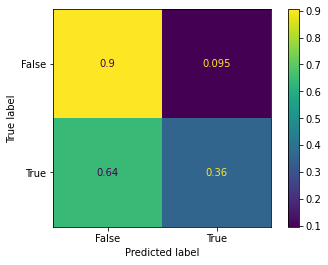

In [ ]:
mt = ModelTrainer(tf_vectorizer, log_reg)
mt.fit(dp_train)
mt.valid(dp_valid)

### [BERT explained](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270#:~:text=BERT%20(Bidirectional%20Encoder%20Representations%20from,researchers%20at%20Google%20AI%20Language.&text=The%20paper's%20results%20show%20that,than%20single%2Ddirection%20language%20models.)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

In [ ]:
from torch import nn
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


class BertEmbedder:

  max_seq_len = 128
  batch_size = 128
  device = "cuda:0"

  def __init__(self, model_path_or_name):
    self.tokenizer = BertTokenizer.from_pretrained(model_path_or_name)
    self.model = BertModel.from_pretrained(model_path_or_name)
    self.model.eval()
    self.model = self.model.to(self.device)

  def fit_transform(self, samples):
    return self._transform(samples)

  def transform(self, samples):
    return self._transform(samples)

  def _transform(self, samples):
    embeddings = self.bert_vectors(samples)
    return embeddings

  def prepare_samples(self, samples):
    input_ids = []
    for sample in tqdm(samples):
      for sent in sample.split(DataProcessor.sentence_separator):
          encoded_sent = self.tokenizer.encode(sent, add_special_tokens = True)
          input_ids.append(encoded_sent[:self.max_seq_len])
    input_ids = pad_sequences(
        input_ids, maxlen=self.max_seq_len, dtype="long", value=0, truncating="post", padding="post"
    )
    attention_masks = []
    for sent in input_ids:
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return input_ids, attention_masks
 
  def bert_vectors(self, samples):
    input_ids, attention_masks = self.prepare_samples(samples)

    inputs_ids = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    
    dataset = TensorDataset(inputs_ids, masks)
    dataloader = DataLoader(dataset, shuffle=False, batch_size=self.batch_size)
    
    embeddings = []
    with torch.no_grad():
      for batch in tqdm(dataloader):
          batch = tuple(t.to(self.device) for t in batch)
          b_input_ids, b_input_mask = batch
          outputs = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
          embeddings.append(
              outputs["last_hidden_state"][:,0,:].detach().cpu().numpy()
          )
    embeddings = np.concatenate(embeddings)
    emb_pairs = np.reshape(embeddings, (int(embeddings.shape[0] / 2), 
                                        int(embeddings.shape[-1] * 2)))
    return emb_pairs
      

In [ ]:
# run once
#!wget http://files.deeppavlov.ai/deeppavlov_data/bert/sentence_ru_cased_L-12_H-768_A-12_pt.tar.gz
#!tar -xf sentence_ru_cased_L-12_H-768_A-12_pt.tar.gz
#!ls ./sentence_ru_cased_L-12_H-768_A-12_pt
#!mv ./sentence_ru_cased_L-12_H-768_A-12_pt/bert_config.json ./sentence_ru_cased_L-12_H-768_A-12_pt/config.json

In [ ]:
#be = BertEmbedder("bert-base-multilingual-cased")
be = BertEmbedder("./sentence_ru_cased_L-12_H-768_A-12_pt")
log_reg_be = LogisticRegression(solver='liblinear', random_state=17)

100%|██████████| 311/311 [04:50<00:00,  1.07it/s]


Data was featurized


  1%|▏         | 123/8505 [00:00<00:06, 1220.86it/s]

Model was fitted


100%|██████████| 133/133 [02:05<00:00,  1.06it/s]

Classification Report
              precision    recall  f1-score   support

       False       0.70      0.81      0.75      5366
        True       0.56      0.40      0.47      3139

    accuracy                           0.66      8505
   macro avg       0.63      0.61      0.61      8505
weighted avg       0.65      0.66      0.65      8505


Prediction samples
Sample #5462 	 Target label: False 	 Predicted label: False



Sample #1106 	 Target label: False 	 Predicted label: False



Sample #6845 	 Target label: False 	 Predicted label: True



Sample #7933 	 Target label: False 	 Predicted label: False



Sample #8001 	 Target label: False 	 Predicted label: False



Plot confusion matrix


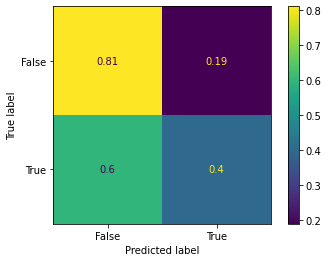

In [ ]:
mt = ModelTrainer(be, log_reg_be)
mt.fit(dp_train)
mt.valid(dp_valid)

## Домашняя работа 
**Варинт 1**. Максимально количество баллов: 7

Вы работаете над уже написанными классами и их улучшением для решения задачи RUSSE. 

Что можно сделать?

*   Снять морфологическую омонимию 
*   Попробовать иные параметры для TF-IDF (включаю работу на символах, а не словах)
*   Добавить другие модели для бинарной классификации, если вы знаете (деревья, например) 

Все это творчество оценивается максимум в 3 балла, при условии того, что это вписано в существующие классы или заведены новые

**Вариает 2**. Максимально количество баллов: 9

Переписываете, дописываете существующий пайплайн работы и при этом решаете задачу TERRa

Что делать? 

*   Знакомитесь с задаче и придумываете как ее можно решить, с помощью тех методов, о которых вы знаете

Все это творчество оценивается максимум в 5 баллов, при условии того, что это вписано в существующие классы или заведены новые

**Оценивается и должно быть в обоих вариантах**: 


*   Вы написали AbstractStep и от него отнаследовали все классы (он может иметь только один общий метод, например вернуть имя класса - задача больше учебная чем функциональная) - 1 балла
*   Вы написали CustomPipeline, который на вход принимает все ваши степы (reader, processor, trainer) и имеет функционал run, который запускает все эти шаги в правльной последовательности и выполняет необходимые методы для обучения и валидации - 1 балла
*  Вы добавили шаг Statistics - принимает на вход DataFrame и вовзращает важные, по вашему мнению дескриптивные статистики по данному набору данных, может ничего не возвращать,а может исходный DataFrame - 2 балла



К каждому из вариантов добавляется **один балл сверху**, если вы зарегистрировались и сделали сабмит своих результатов на сайте Russian SuperGlue. Подразумевается, что код, который создает submition.json также присутствует в тетрадке.

Напомню в первую очередь оценивает работа с классами и скилл программирования, во вторую - результат моделей

In [ ]:
!wget https://russiansuperglue.com/tasks/download/TERRa

--2020-12-13 18:36:23--  https://russiansuperglue.com/tasks/download/TERRa
Resolving russiansuperglue.com (russiansuperglue.com)... 80.66.93.142
Connecting to russiansuperglue.com (russiansuperglue.com)|80.66.93.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 907346 (886K) [application/zip]
Saving to: ‘TERRa’

TERRa               100%[===================>] 886.08K   720KB/s    in 1.2s    

2020-12-13 18:36:25 (720 KB/s) - ‘TERRa’ saved [907346/907346]



In [ ]:
!mv TERRa TERRa.zip

In [ ]:
!unzip TERRa.zip

Archive:  TERRa.zip
   creating: TERRa/
  inflating: TERRa/train.jsonl       
   creating: __MACOSX/
   creating: __MACOSX/TERRa/
  inflating: __MACOSX/TERRa/._train.jsonl  
  inflating: TERRa/.DS_Store         
  inflating: __MACOSX/TERRa/._.DS_Store  
  inflating: TERRa/test.jsonl        
  inflating: __MACOSX/TERRa/._test.jsonl  
  inflating: TERRa/val.jsonl         
  inflating: __MACOSX/TERRa/._val.jsonl  
  inflating: __MACOSX/._TERRa        


In [ ]:
!head TERRa/train.jsonl

{"premise": "Женщину доставили в больницу, за ее жизнь сейчас борются врачи.", "hypothesis": "Женщину спасают врачи.", "label": "entailment", "idx": 0}
{"premise": "Он проводит невидимую грань между настоящим и будущим. В эти минуты все мы подводим главные итоги года, вспоминаем самые важные события. В эти мгновения мы с волнением ждем добрых перемен.", "hypothesis": "В эти минуты все мы подводим друг друга.", "label": "not_entailment", "idx": 1}
{"premise": "Мужчина рассказал: детская коляска, принадлежащая его семье, пропала прямо из подъезда. Как выяснили полицейские, коляску украл сосед мужчины. Он был пьян, и ему нужны были деньги.", "hypothesis": "Сосед часто крадет детские коляски ради денег.", "label": "not_entailment", "idx": 2}
{"premise": "Я просто об этом даже не думаю, потому что если кто-то что-то захочет, никуда не спрячешься.", "hypothesis": "Спрятаться не удастся.", "label": "entailment", "idx": 3}
{"premise": "В ходе проверки нашли дома с наледью и сосульками на крыша